In [1]:
import docx
import pandas as pd
import numpy as np
from yellowbrick.regressor import PredictionError, ResidualsPlot
from docx import Document
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from sklearn.impute import KNNImputer
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report, confusion_matrix
import math
from PIL import Image

There Were About 5 Datasets, But only 3 Will be Isolated for the Capstone Project

In [3]:
##Loading time series data for regression task while also passing the date
DW = pd.read_excel('C:/Users/AFRIFA/Documents/CAPSTONE TASK/day_wise.xlsx', index_col ='Date', parse_dates =True )

In [5]:
## dropping irrelevant columns
DW=DW.drop(["Deaths / 100 Cases", "Recovered / 100 Cases", "Deaths / 100 Recovered", "No. of countries"], axis =1)

In [7]:
## checking data
DW.head()

,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered
Date,,,,,,,
2020-01-22,555,17,28,510,0,0,0
2020-01-23,654,18,30,606,99,1,2
2020-01-24,941,26,36,879,287,8,6
2020-01-25,1434,42,39,1353,493,16,3
2020-01-26,2118,56,52,2010,684,14,13


In [9]:
## checking for missing observations
DW.isnull().sum()

Confirmed        0
Deaths           0
Recovered        0
Active           0
New cases        0
New deaths       0
New recovered    0
dtype: int64

In [11]:
##checking for duplicated
DW.duplicated().sum()

0

In [13]:
##checking datatypes
DW.dtypes

Confirmed        int64
Deaths           int64
Recovered        int64
Active           int64
New cases        int64
New deaths       int64
New recovered    int64
dtype: object

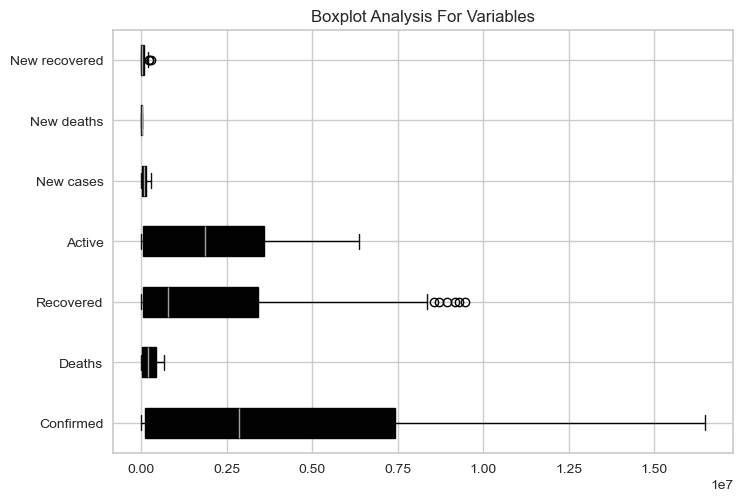

In [15]:
##Boxplot for decting outliers

DW.boxplot(patch_artist=True, vert=False)
plt.title('Boxplot Analysis For Variables')
plt.savefig("Out.png")
plt.show()

In [17]:
##Correlation matrix for relationship and data distribution
sns.set_theme(style ="ticks")
sns.pairplot(DW)
plt.savefig("scatter.png")

In [18]:
## Renaming Columns
DW=DW.rename(columns={"Confirmed":  "Confirmed_Cases", 
                      "Deaths": "Mortality_Rate",
                      "Recovered":  "Recovery_Rate",
                     "Active": "Active_Cases",
                     "New cases": "New_Cases",
                     "New deaths": "New_Deaths",
                     "New recovered": "New_Recovery_Rate"}) 

In [21]:
##Descriptive Statistics
DT=DW.describe()
DT

,Confirmed_Cases,Mortality_Rate,Recovery_Rate,Active_Cases,New_Cases,New_Deaths,New_Recovery_Rate
count,1.880000e+02,188.000000,1.880000e+02,1.880000e+02,188.000000,188.000000,188.000000
mean,4.406960e+06,230770.760638,2.066001e+06,2.110188e+06,87771.021277,3478.824468,50362.015957
std,4.757988e+06,217929.094183,2.627976e+06,1.969670e+06,75295.293255,2537.735652,56090.892479
min,5.550000e+02,17.000000,2.800000e+01,5.100000e+02,0.000000,0.000000,0.000000
25%,1.121910e+05,3935.000000,6.044125e+04,5.864175e+04,5568.500000,250.750000,2488.250000
50%,2.848733e+06,204190.000000,7.847840e+05,1.859759e+06,81114.000000,4116.000000,30991.500000
75%,7.422046e+06,418634.500000,3.416396e+06,3.587015e+06,131502.500000,5346.000000,79706.250000
max,1.648048e+07,654036.000000,9.468087e+06,6.358362e+06,282756.000000,9966.000000,284394.000000


In [23]:
##Exporting the descriptive statistics result to word document
doc = Document()
doc.add_heading("DT", level=1)
table=doc.add_table(rows=DT.shape[0]+ 1, cols =DT.shape[1]+ 1)
table.cell(0, 0).text="" 
for i, col in enumerate(DT.columns):
    table.cell(0, i +1).text=col
    table.cell(i+1, 0).text=col
for i, row in enumerate(DT.itertuples( index = False)):
    for j, value in enumerate(row):
        table.cell(i+1, j + 1).text= f"{value:.2f}"
doc.save("myres.docx")

In [25]:
##Correlation analysis
result=DW.corr()
result

,Confirmed_Cases,Mortality_Rate,Recovery_Rate,Active_Cases,New_Cases,New_Deaths,New_Recovery_Rate
Confirmed_Cases,1.000000,0.975981,0.990165,0.986543,0.961473,0.555479,0.944875
Mortality_Rate,0.975981,1.000000,0.936940,0.996879,0.952450,0.625537,0.923130
Recovery_Rate,0.990165,0.936940,1.000000,0.953981,0.936576,0.476217,0.935754
Active_Cases,0.986543,0.996879,0.953981,1.000000,0.967578,0.637241,0.931824
New_Cases,0.961473,0.952450,0.936576,0.967578,1.000000,0.721846,0.928570
New_Deaths,0.555479,0.625537,0.476217,0.637241,0.721846,1.000000,0.555759
New_Recovery_Rate,0.944875,0.923130,0.935754,0.931824,0.928570,0.555759,1.000000


In [27]:
## exporting the correlation matrix to word
doc = Document()
doc.add_heading("result", level=1)
table=doc.add_table(rows=result.shape[0]+ 1, cols =result.shape[1]+ 1)
table.cell(0, 0).text="" 
for i, col in enumerate(result.columns):
    table.cell(0, i +1).text=col
    table.cell(i+1, 0).text=col
for i, row in enumerate(result.itertuples( index = False)):
    for j, value in enumerate(row):
        table.cell(i+1, j + 1).text= f"{value:.2f}"
doc.save("myres1.docx")

In [29]:
## Feature Engineering. Computing daily growths rate and covid realities per 100 confirmed cases

DW['Daily_Growth_Rate_of_Confirmed_Cases'] =DW['Confirmed_Cases'].pct_change(periods =1)*100
DW['Daily_Growth_Rate_of_Mortality'] =DW['Mortality_Rate'].pct_change(periods =1)*100
DW['Daily_Growth_Rate_of_Recovered_Cases'] =DW['Recovery_Rate'].pct_change(periods =1)*100
DW['Daily_Growth_Rate_of_Active_Cases'] =DW['Active_Cases'].pct_change(periods =1)*100
DW['Mortality_Rate_Per_100Cases_Confirmed']=(DW['Mortality_Rate'])/(DW['Confirmed_Cases']/100)
DW['Recovery_Rate_Per_100Cases_Confirmed']=(DW['Recovery_Rate'])/(DW['Confirmed_Cases']/100)
DW['Active_Cases_Per_100Cases_Confirmed']=(DW['Active_Cases'])/(DW['Confirmed_Cases']/100)

In [31]:
## Checking for missing values
DW.isnull().sum()

Confirmed_Cases                          0
Mortality_Rate                           0
Recovery_Rate                            0
Active_Cases                             0
New_Cases                                0
New_Deaths                               0
New_Recovery_Rate                        0
Daily_Growth_Rate_of_Confirmed_Cases     1
Daily_Growth_Rate_of_Mortality           1
Daily_Growth_Rate_of_Recovered_Cases     1
Daily_Growth_Rate_of_Active_Cases        1
Mortality_Rate_Per_100Cases_Confirmed    0
Recovery_Rate_Per_100Cases_Confirmed     0
Active_Cases_Per_100Cases_Confirmed      0
dtype: int64

In [33]:
## dropping missing values
DW=DW.dropna()

In [35]:
DW.head(1)

,Confirmed_Cases,Mortality_Rate,Recovery_Rate,Active_Cases,New_Cases,New_Deaths,New_Recovery_Rate,Daily_Growth_Rate_of_Confirmed_Cases,Daily_Growth_Rate_of_Mortality,Daily_Growth_Rate_of_Recovered_Cases,Daily_Growth_Rate_of_Active_Cases,Mortality_Rate_Per_100Cases_Confirmed,Recovery_Rate_Per_100Cases_Confirmed,Active_Cases_Per_100Cases_Confirmed
Date,,,,,,,,,,,,,,
2020-01-23,654,18,30,606,99,1,2,17.837838,5.882353,7.142857,18.823529,2.752294,4.587156,92.66055


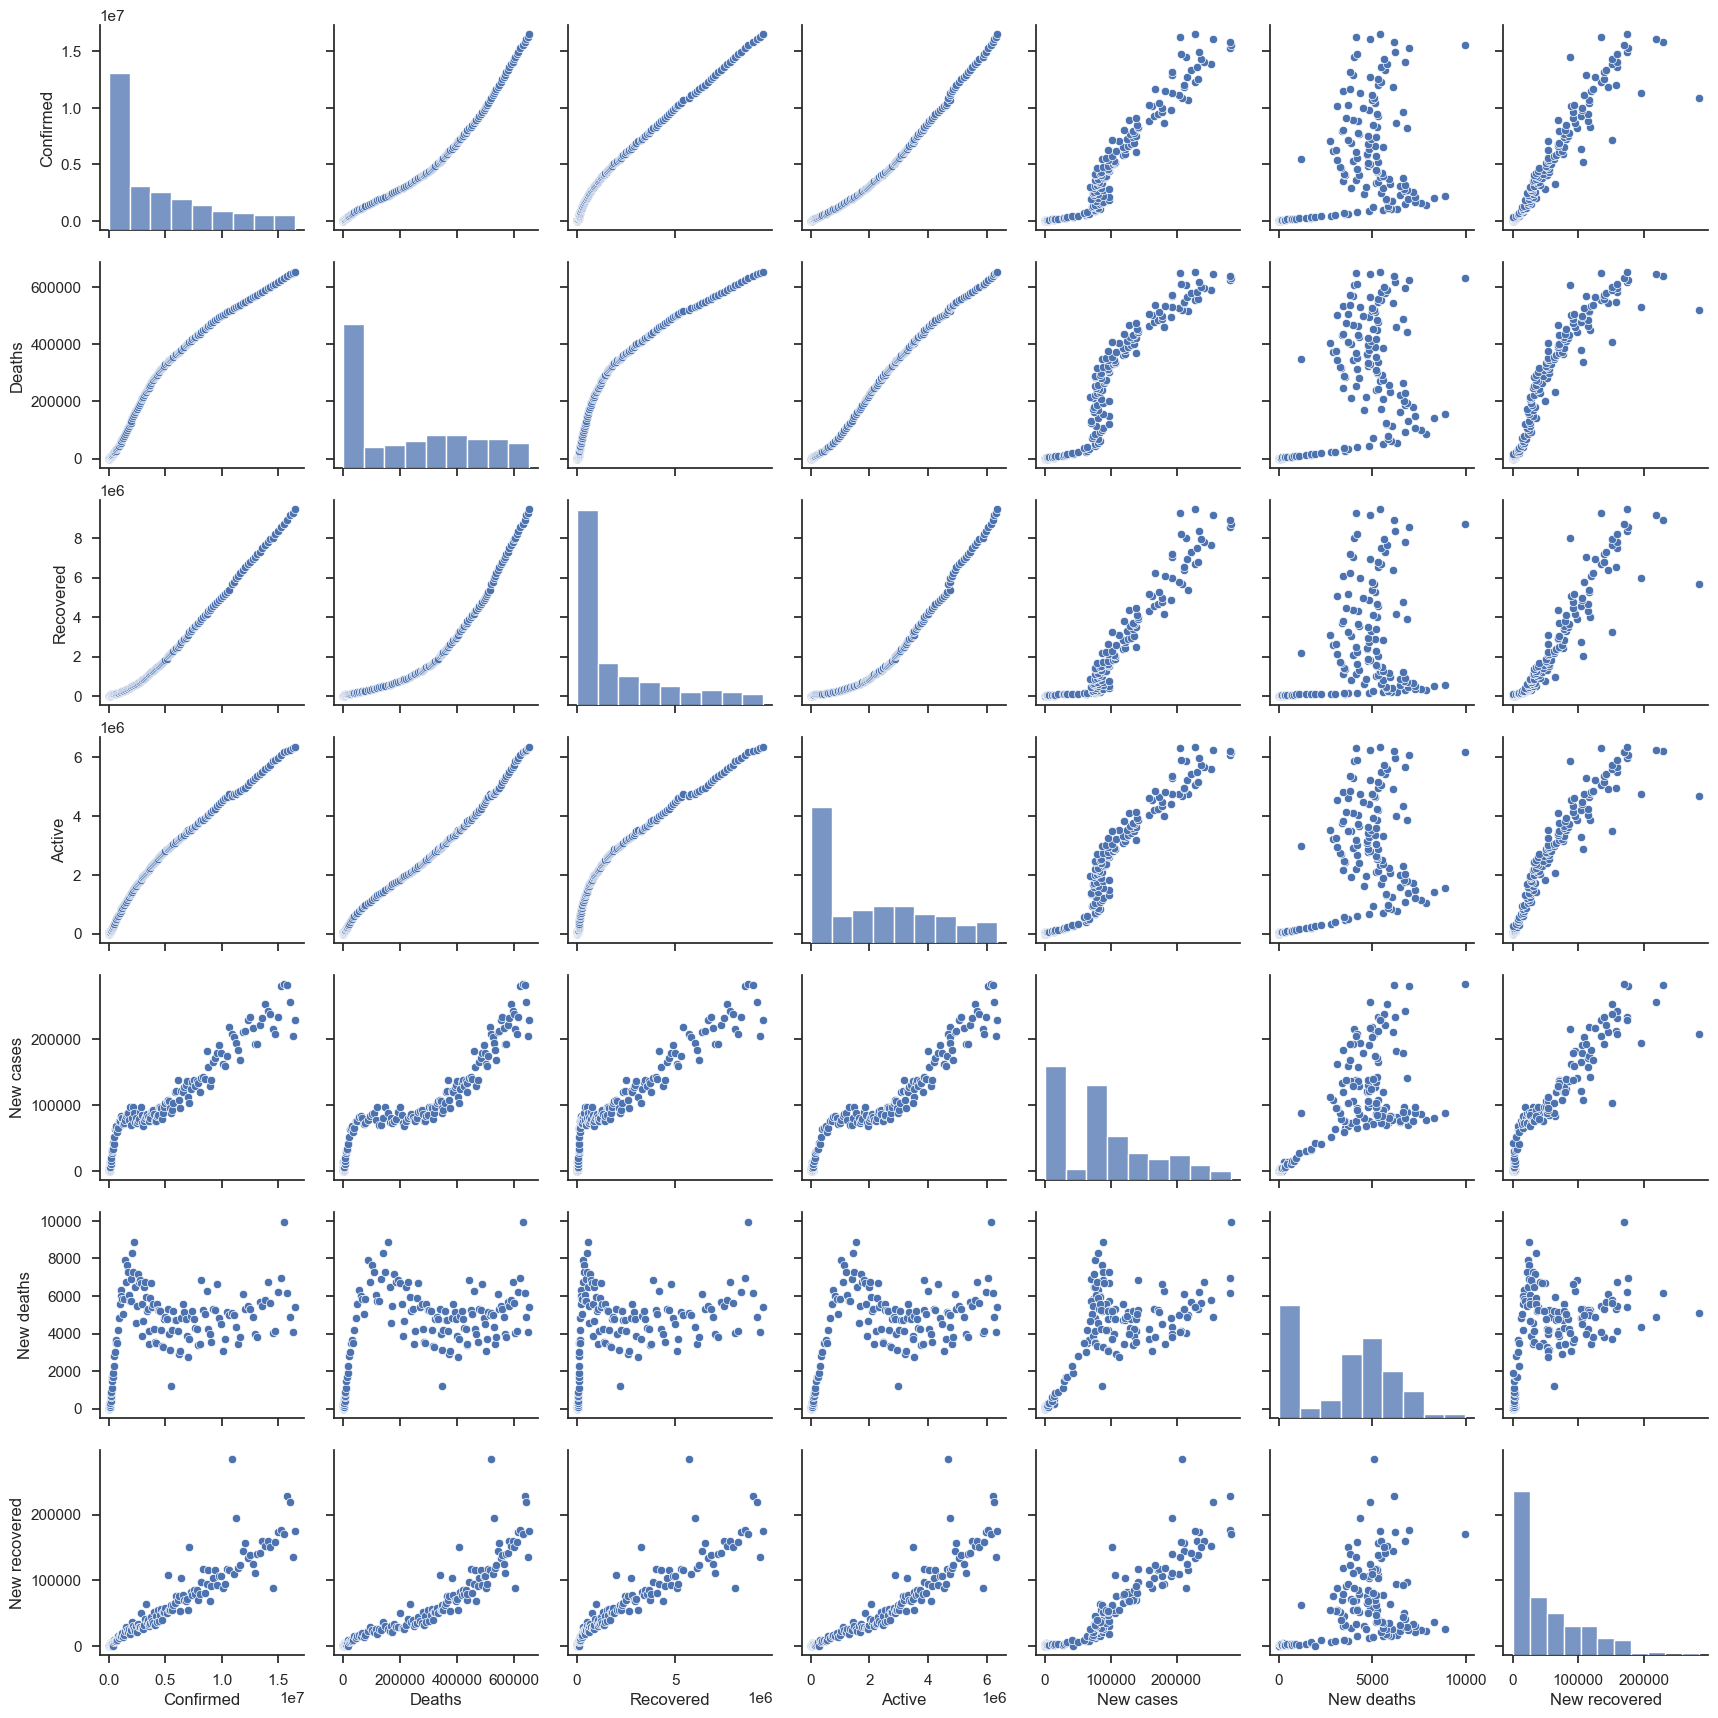

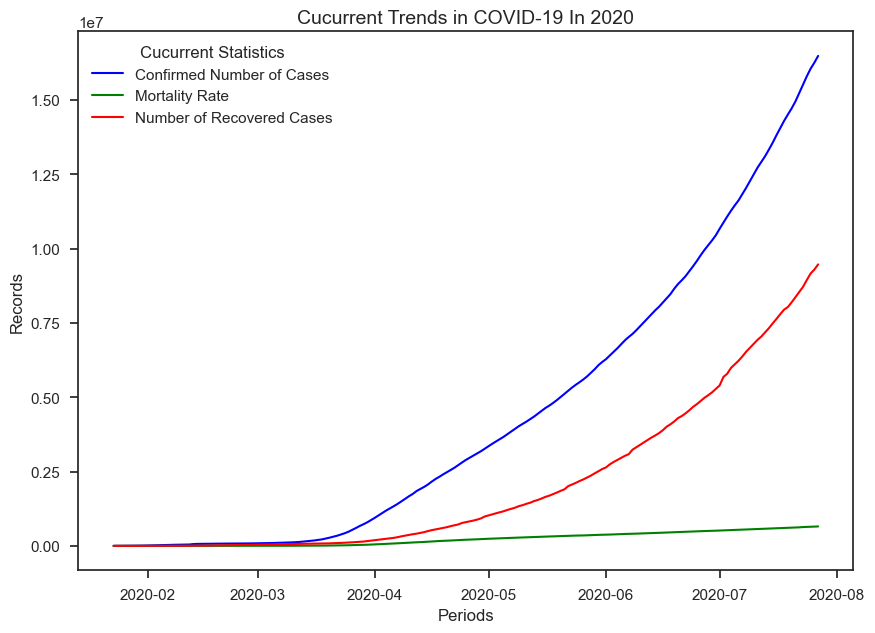

In [37]:
##Time series visualisation

plt.figure(figsize =(10,7))
plt.plot(DW["Confirmed_Cases"], label ='Confirmed Number of Cases', color ='blue')
plt.plot(DW["Mortality_Rate"], label= 'Mortality Rate', color ='green')
plt.plot(DW["Recovery_Rate"], label = 'Number of Recovered Cases', color ='red')
plt.legend(title ='Cucurrent Statistics')
plt.ylabel('Records',  fontsize=12)
plt.xlabel('Periods',  fontsize=12)
plt.title('Cucurrent Trends in COVID-19 In 2020',  fontsize=14)
plt.savefig("C1.png")
plt.show()

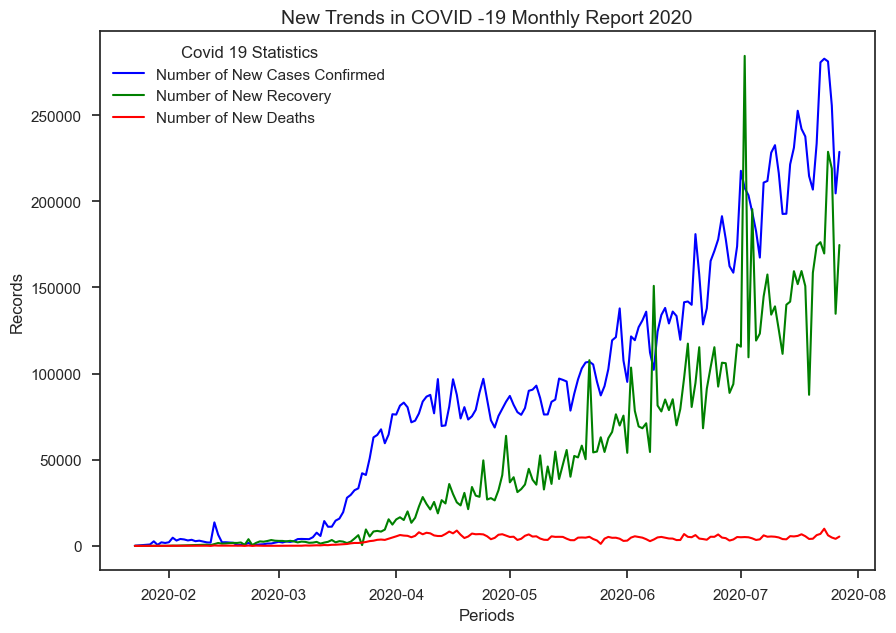

In [38]:
##time series visualisation
plt.figure(figsize =(10,7))
plt.plot(DW["New_Cases"], label ='Number of New Cases Confirmed', color ='blue')
plt.plot(DW["New_Recovery_Rate"], label= 'Number of New Recovery', color ='green')
plt.plot(DW["New_Deaths"], label = 'Number of New Deaths', color ='red')
plt.legend(title ='Covid 19 Statistics')
plt.ylabel('Records',  fontsize=12)
plt.xlabel('Periods',  fontsize=12)
plt.title('New Trends in COVID -19 Monthly Report 2020',  fontsize=14)
plt.savefig("C2.png")
plt.show()

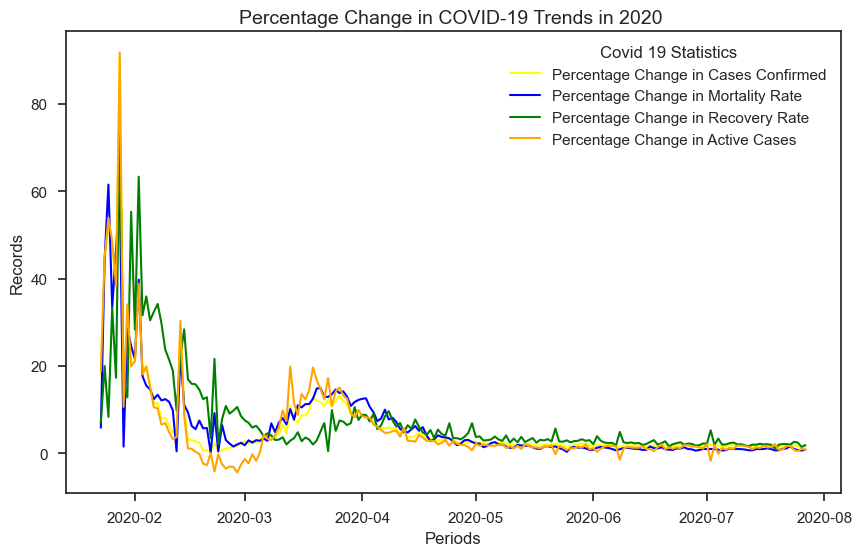

In [39]:
##Time series visualisation
plt.figure(figsize =(10,6))
plt.plot(DW["Daily_Growth_Rate_of_Confirmed_Cases"], label ='Percentage Change in Cases Confirmed', color ='yellow')
plt.plot(DW['Daily_Growth_Rate_of_Mortality'], label ='Percentage Change in Mortality Rate', color ='blue')
plt.plot(DW['Daily_Growth_Rate_of_Recovered_Cases'], label ='Percentage Change in Recovery Rate', color ='green')
plt.plot(DW['Daily_Growth_Rate_of_Active_Cases'], label ='Percentage Change in Active Cases', color ='orange')
plt.legend(title ='Covid 19 Statistics')
plt.ylabel('Records',  fontsize=12)
plt.xlabel('Periods',  fontsize=12)
plt.title('Percentage Change in COVID-19 Trends in 2020 ',  fontsize=14)
plt.savefig("C3.png")
plt.show()

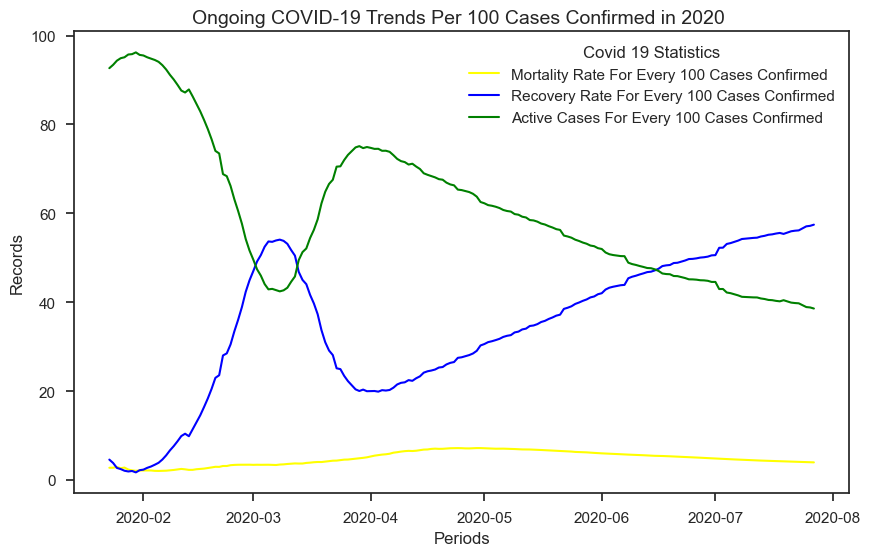

In [40]:
##Time series visualisation
plt.figure(figsize =(10,6))
plt.plot(DW["Mortality_Rate_Per_100Cases_Confirmed"], label ='Mortality Rate For Every 100 Cases Confirmed', color ='yellow')
plt.plot(DW['Recovery_Rate_Per_100Cases_Confirmed'], label ='Recovery Rate For Every 100 Cases Confirmed', color ='blue')
plt.plot(DW['Active_Cases_Per_100Cases_Confirmed'], label ='Active Cases For Every 100 Cases Confirmed', color ='green')
plt.legend(title ='Covid 19 Statistics')
plt.ylabel('Records',  fontsize=12)
plt.xlabel('Periods',  fontsize=12)
plt.title('Ongoing COVID-19 Trends Per 100 Cases Confirmed in 2020 ',  fontsize=14)
plt.savefig("C4.png")
plt.show()

In [45]:
##Stationarity Test at Level
ADF = adfuller(DW['Confirmed_Cases'])
print('ADF Statistics: %f' % ADF[0])
print('Probability Values: %f' % ADF[1])
print('Critical Values:')
for key, value in ADF[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistics: 2.070035
Probability Values: 0.998757
Critical Values:
	1%: -3.468
	5%: -2.878
	10%: -2.576


In [46]:
ADF = adfuller(DW['Mortality_Rate'])
print('ADF Statistics: %f' % ADF[0])
print('Probability Values: %f' % ADF[1])
print('Critical Values:')
for key, value in ADF[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistics: 1.204969
Probability Values: 0.996020
Critical Values:
	1%: -3.469
	5%: -2.878
	10%: -2.576


In [49]:
ADF = adfuller(DW['Recovery_Rate'])
print('ADF Statistics: %f' % ADF[0])
print('Probability Values: %f' % ADF[1])
print('Critical Values:')
for key, value in ADF[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistics: 2.784931
Probability Values: 1.000000
Critical Values:
	1%: -3.467
	5%: -2.878
	10%: -2.575


In [51]:
ADF = adfuller(DW['Active_Cases'])
print('ADF Statistics: %f' % ADF[0])
print('Probability Values: %f' % ADF[1])
print('Critical Values:')
for key, value in ADF[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistics: 1.667732
Probability Values: 0.998047
Critical Values:
	1%: -3.467
	5%: -2.878
	10%: -2.575


In [53]:
##Taking thr First Difference
DW['D_Confirmed_Cases'] = DW['Confirmed_Cases'] - DW['Confirmed_Cases'].shift(1)
DW['D_Mortality_Rate'] = DW['Mortality_Rate'] - DW['Mortality_Rate'].shift(1)
DW['D_Active_Cases'] = DW['Active_Cases'] - DW['Active_Cases'].shift(1)
DW['D_Recovered'] = DW['Recovery_Rate'] - DW['Recovery_Rate'].shift(1)

In [55]:
##Sdropping missing observation
DW=DW.dropna()

In [57]:
##Stationarity Test at First Difference
ADF = adfuller(DW['D_Confirmed_Cases'])
print('ADF Statistics: %f' % ADF[0])
print('Probability Values: %f' % ADF[1])
print('Critical Values:')
for key, value in ADF[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistics: 0.545691
Probability Values: 0.986198
Critical Values:
	1%: -3.469
	5%: -2.879
	10%: -2.576


In [59]:
ADF = adfuller(DW['D_Mortality_Rate'])
print('ADF Statistics: %f' % ADF[0])
print('Probability Values: %f' % ADF[1])
print('Critical Values:')
for key, value in ADF[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistics: -1.833624
Probability Values: 0.363901
Critical Values:
	1%: -3.469
	5%: -2.878
	10%: -2.576


In [61]:
ADF = adfuller(DW['D_Active_Cases'])
print('ADF Statistics: %f' % ADF[0])
print('Probability Values: %f' % ADF[1])
print('Critical Values:')
for key, value in ADF[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistics: -2.031089
Probability Values: 0.273110
Critical Values:
	1%: -3.467
	5%: -2.878
	10%: -2.575


In [63]:
ADF = adfuller(DW['D_Recovered'])
print('ADF Statistics: %f' % ADF[0])
print('Probability Values: %f' % ADF[1])
print('Critical Values:')
for key, value in ADF[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistics: 1.851497
Probability Values: 0.998446
Critical Values:
	1%: -3.468
	5%: -2.878
	10%: -2.576


In [65]:
##Checking for missing values
DW.isnull().sum()

Confirmed_Cases                          0
Mortality_Rate                           0
Recovery_Rate                            0
Active_Cases                             0
New_Cases                                0
New_Deaths                               0
New_Recovery_Rate                        0
Daily_Growth_Rate_of_Confirmed_Cases     0
Daily_Growth_Rate_of_Mortality           0
Daily_Growth_Rate_of_Recovered_Cases     0
Daily_Growth_Rate_of_Active_Cases        0
Mortality_Rate_Per_100Cases_Confirmed    0
Recovery_Rate_Per_100Cases_Confirmed     0
Active_Cases_Per_100Cases_Confirmed      0
D_Confirmed_Cases                        0
D_Mortality_Rate                         0
D_Active_Cases                           0
D_Recovered                              0
dtype: int64

In [66]:
##Isolating Data for Analysis, three features and 1 Targer
XYDF=(DW[['D_Confirmed_Cases', 'D_Mortality_Rate', 'D_Active_Cases', 'D_Recovered']])

In [69]:
## Spliting Data to Training and Test
Train_Data='2020-06-20'
Test_Data ='2020-06-21'
Train=XYDF.loc[:Train_Data]
Test=XYDF.loc[Test_Data:]

In [70]:
##Data Transformation: Trasnforming Features
TT = StandardScaler()
TT =TT.fit_transform(Train)
Scaled_T =pd.DataFrame(TT, columns =Train.columns)

In [73]:
##Data Transformation: Trasnforming Target
TS = StandardScaler()
TS =TS.fit_transform(Test)
Scaled_TS =pd.DataFrame(TS, columns =Test.columns)

In [75]:
##Selecting Features anbd Target for Model Development
X_Train=(Scaled_T[['D_Confirmed_Cases', 'D_Active_Cases', 'D_Recovered']]).values 
X_Test=(Scaled_TS[['D_Confirmed_Cases', 'D_Active_Cases', 'D_Recovered']]).values 
Y_Train=(Scaled_T['D_Mortality_Rate']).values
Y_Test=(Scaled_TS['D_Mortality_Rate']).values

In [77]:
##Building the Support Vector Regression Model
SVR_L=SVR(kernel= 'rbf').fit(X_Train,  Y_Train)

In [79]:
Y_Train_P=SVR_L.predict(X_Train)

In [81]:
Y_Test_P=SVR_L.predict(X_Test)

In [83]:
##Model Evaluation with Train Datasets
print('R-Sqaure: %.2f'%r2_score(Y_Train, Y_Train_P))
print('Mean Absolute Error: %.2f'%mean_absolute_error(Y_Train, Y_Train_P))
print('Mean Square Error: %.2f'%mean_squared_error(Y_Train, Y_Train_P))
print('Root Mean Square Error: %.2f'%np.sqrt(mean_squared_error(Y_Train, Y_Train_P)))
print('Explained Variance Score: %.2f'% explained_variance_score(Y_Train, Y_Train_P))

R-Sqaure: 0.89
Mean Absolute Error: 0.22
Mean Square Error: 0.11
Root Mean Square Error: 0.34
Explained Variance Score: 0.89


In [85]:
##Model Evaluation with Test Datasets
print('R-Sqaure: %.2f'%r2_score(Y_Test, Y_Test_P))
print('Mean Absolute Error: %.2f'%mean_absolute_error(Y_Test, Y_Test_P))
print('Mean Square Error: %.2f'%mean_squared_error(Y_Test, Y_Test_P))
print('Root Mean Square Error: %.2f'%np.sqrt(mean_squared_error(Y_Test, Y_Test_P)))
print('Explained Variance Score: %.2f'% explained_variance_score(Y_Test, Y_Test_P))

R-Sqaure: 0.20
Mean Absolute Error: 0.69
Mean Square Error: 0.80
Root Mean Square Error: 0.90
Explained Variance Score: 0.21


In [87]:
print(Y_Test_P[:10])

[-0.52084935 -0.89592573 -0.96223015 -0.83535004 -0.81042398 -0.3702141
 -0.73064934 -0.94050605 -0.98161537 -0.76851959]


In [89]:
####Checking the Actaul vs Predicted Values
Estimates=pd.DataFrame({'Actual_Values':Y_Test,'Predicted Values':Y_Test_P})

In [91]:
Estimates.head(10)

,Actual_Values,Predicted Values
0,-0.907618,-0.520849
1,-1.219689,-0.895926
2,0.165524,-0.962230
3,0.125719,-0.835350
4,1.213192,-0.810424
5,-0.219788,-0.370214
6,-0.491258,-0.730649
7,-1.603410,-0.940506
8,-1.100274,-0.981615
9,0.023022,-0.768520


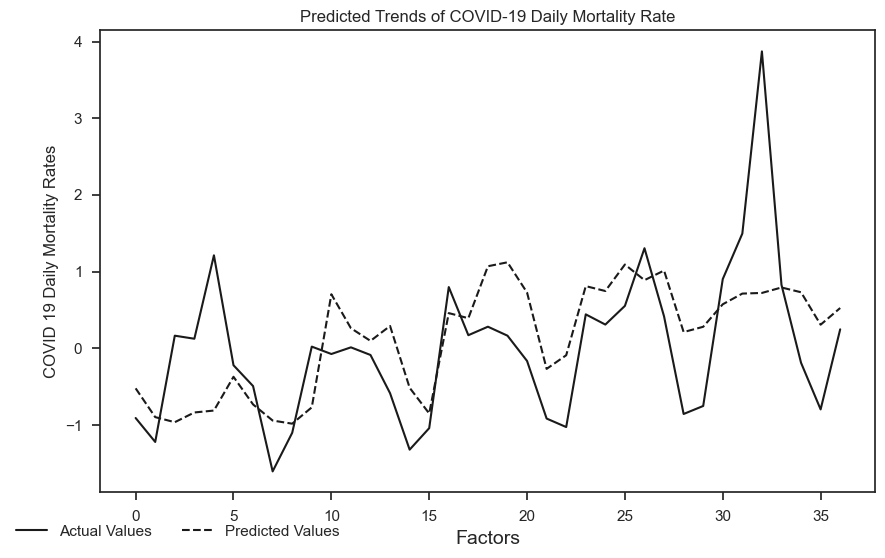

In [93]:

##Plotting the Predicted vs Actual Values
plt.rcParams['figure.figsize'] = (10, 6)
x_ax = range(len(X_Test))
plt.plot(x_ax, Y_Test, label= 'Actual Values', color ='k', linestyle ='-')
plt.plot(x_ax, Y_Test_P, label= 'Predicted Values', color ='k', linestyle ='--')
plt.ylabel('COVID 19 Daily Mortality Rates')
plt.xlabel('Factors',  fontsize=14) 
plt.title('Predicted Trends of COVID-19 Daily Mortality Rate')
plt.legend(bbox_to_anchor = (0.10, -.13), loc ='lower center', ncol = 2, frameon =False)
plt.savefig("C5.png")
plt.show()

In [ ]:
##Plotting prediction  Errors
plt.figure(figsize =(10,6))
vis=  PredictionError(SVR_L)
vis.fit(X_Train, Y_Train)
vis.score(X_Test, Y_Test)
vis.poof(outpath="pred_Err.png")

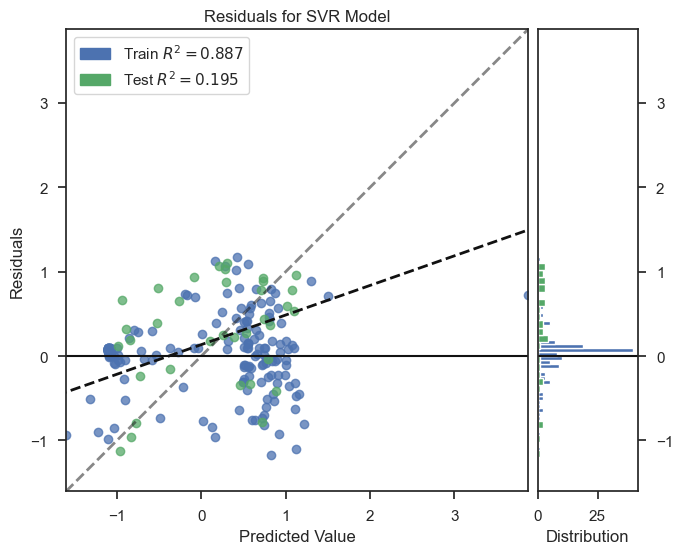

In [97]:
##Plotting Errors
vis =  ResidualsPlot(SVR_L)
vis.fit(X_Train, Y_Train)
vis.score(X_Test, Y_Test)
vis.poof(outpath="Rsidplot.png")
plt.show()

In [99]:
##Checking Cross validation Score
scoreT=cross_val_score(SVR_L, X_Train, Y_Train, scoring ='r2', cv=10)
print(scoreT)

[-49.68683678  -8.13606957 -20.66115184   0.95370761   0.12256541
  -2.28794945  -0.93299456  -1.56753675  -0.46331844  -0.09648319]


In [101]:
print(np.mean(scoreT))

-8.27560675762237


In [103]:
scoreT=cross_val_score(SVR_L, X_Test, Y_Test, scoring ='r2', cv=10)
print(scoreT)
print(np.mean(scoreT))

[-4.40418285e-01 -8.80449085e-02 -8.79823792e-05 -1.03932241e+00
 -4.15758400e+00  1.26537420e-01  3.04209688e-01  3.23797656e-01
 -2.04170744e+00 -1.09509803e+00]
-0.8107718289168162


In [174]:
## second  Datasets for EDA
CW = pd.read_excel('C:/Users/AFRIFA/Documents/CAPSTONE TASK/country_wise_latest.xlsx' )

In [176]:
##Checking
CW.head(1)

,Country/Region,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,Confirmed last week,1 week change,1 week % increase,WHO Region
0,Afghanistan,36263,1269,25198,9796,106,10,18,3.5,69.49,5.04,35526,737,2.07,Eastern Mediterranean


In [178]:
##Checking
CW.shape

(187, 15)

In [180]:
##checking for Null
CW.isnull().sum()

Country/Region            0
Confirmed                 0
Deaths                    0
Recovered                 0
Active                    0
New cases                 0
New deaths                0
New recovered             0
Deaths / 100 Cases        0
Recovered / 100 Cases     0
Deaths / 100 Recovered    0
Confirmed last week       0
1 week change             0
1 week % increase         0
WHO Region                0
dtype: int64

In [182]:
##Checking data infor
CW.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Country/Region          187 non-null    object 
 1   Confirmed               187 non-null    int64  
 2   Deaths                  187 non-null    int64  
 3   Recovered               187 non-null    int64  
 4   Active                  187 non-null    int64  
 5   New cases               187 non-null    int64  
 6   New deaths              187 non-null    int64  
 7   New recovered           187 non-null    int64  
 8   Deaths / 100 Cases      187 non-null    float64
 9   Recovered / 100 Cases   187 non-null    float64
 10  Deaths / 100 Recovered  187 non-null    float64
 11  Confirmed last week     187 non-null    int64  
 12  1 week change           187 non-null    int64  
 13  1 week % increase       187 non-null    float64
 14  WHO Region              187 non-null    ob

In [184]:
CW.isna().any()

Country/Region            False
Confirmed                 False
Deaths                    False
Recovered                 False
Active                    False
New cases                 False
New deaths                False
New recovered             False
Deaths / 100 Cases        False
Recovered / 100 Cases     False
Deaths / 100 Recovered    False
Confirmed last week       False
1 week change             False
1 week % increase         False
WHO Region                False
dtype: bool

In [186]:
#dropping Irrelevant Columns
CW=CW.drop(["Deaths / 100 Cases", "Country/Region", "Deaths / 100 Recovered", "Recovered / 100 Cases", "Confirmed last week", "1 week change", 
            "1 week % increase"], axis =1)

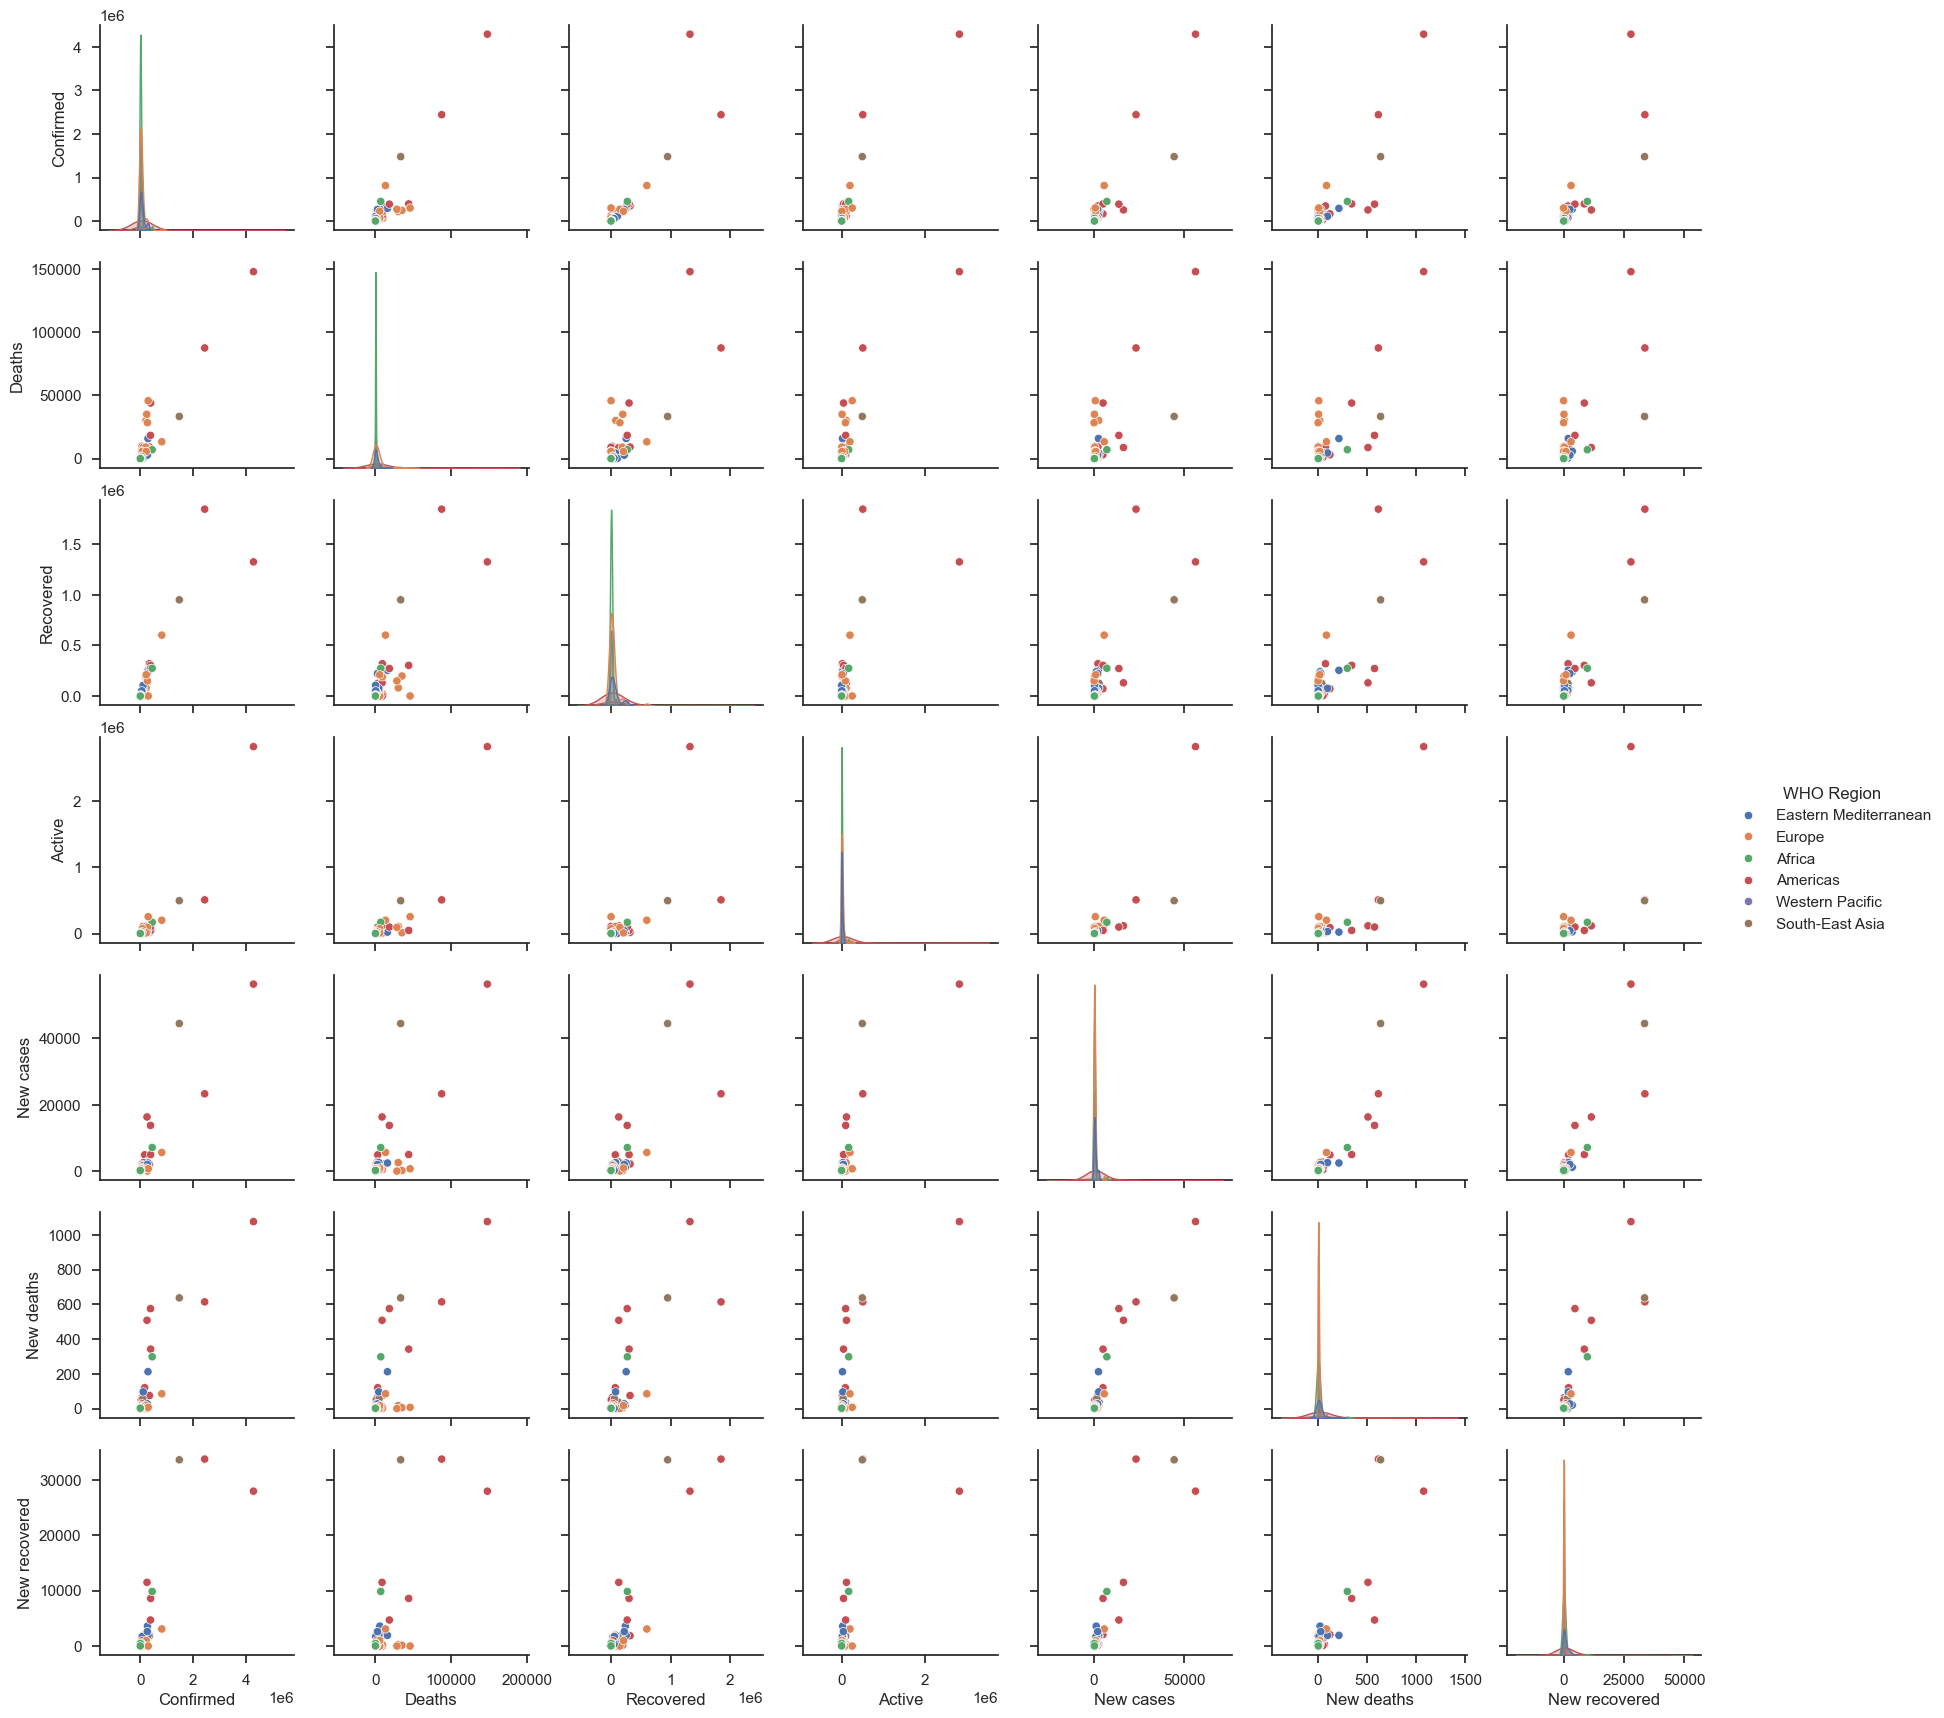

In [188]:
sns.set_theme(style ="ticks")
sns.pairplot(CW, hue="WHO Region")
plt.savefig("cor.png")
plt.show()

In [190]:
##Renaming Columns
CW=CW.rename(columns={"WHO Region":  "WHO_Region", 
                      "New cases": "New_Cases", 
                      "New deaths":  "New_Deaths", 
                      "New recovered":  "New_Recovered"}) 

Building Barchats for Variables bearing in mind the regions

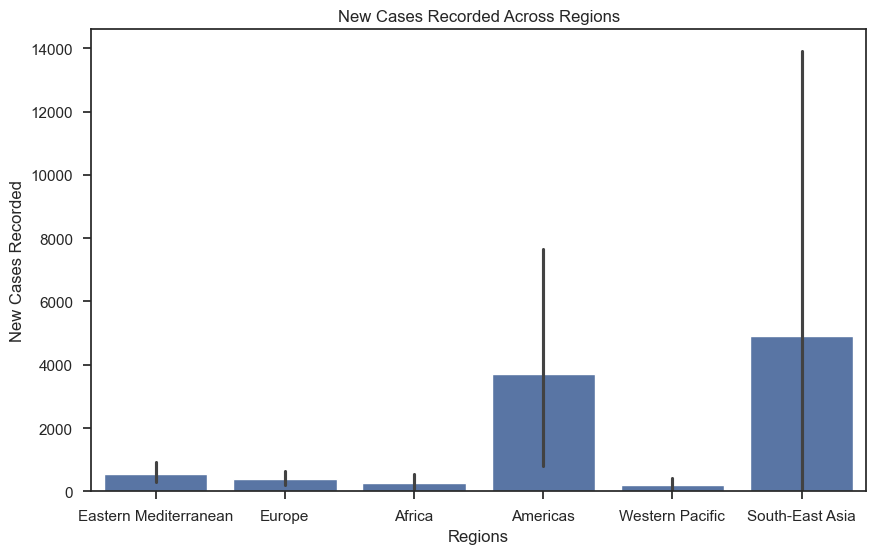

In [193]:

plt.figure(figsize =(10, 6))
sns.barplot(x=CW.WHO_Region, y=CW.New_Cases)
plt.ylabel('New Cases Recorded')
plt.xlabel('Regions')
plt.title('New Cases Recorded Across Regions')
plt.savefig("new_Cases_Reg.png")
plt.show()

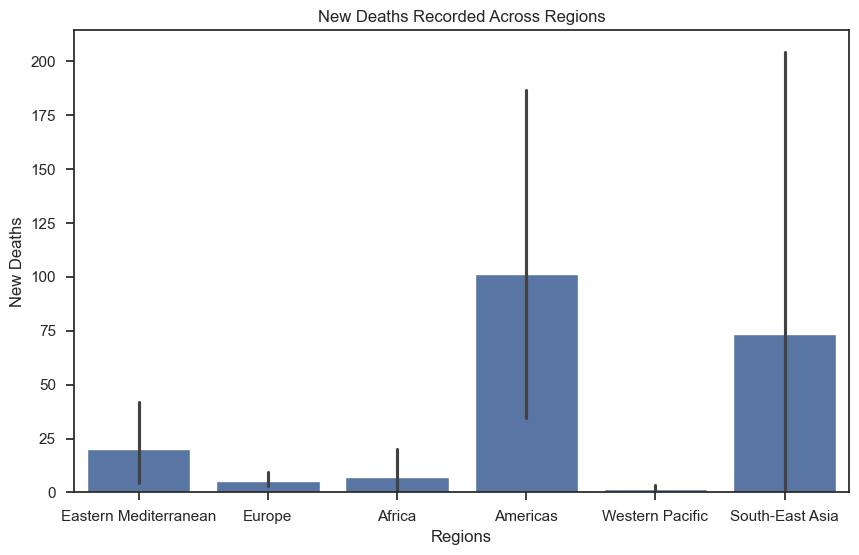

In [195]:
plt.figure(figsize =(10, 6))
sns.barplot(x=CW.WHO_Region, y=CW.New_Deaths)
plt.ylabel('New Deaths')
plt.xlabel('Regions')
plt.title('New Deaths Recorded Across Regions')
plt.savefig("new_deaths_Reg.png")
plt.show()

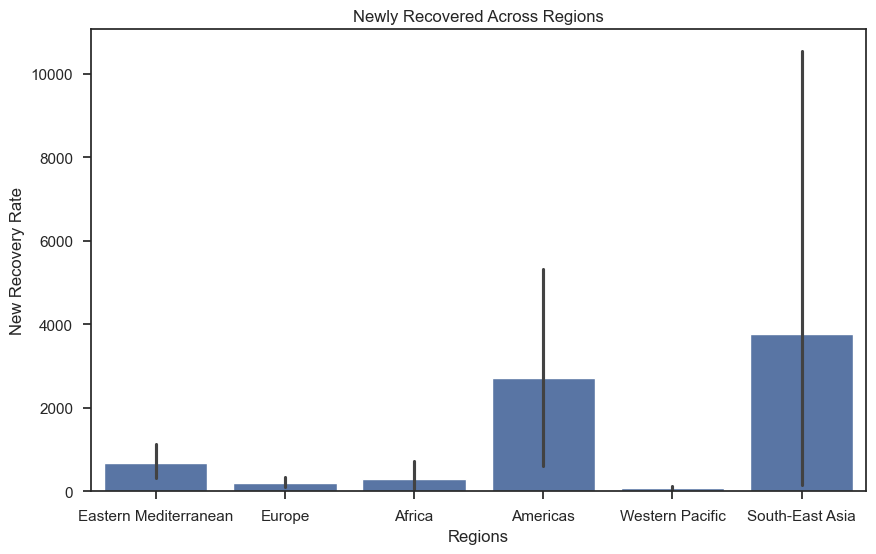

In [196]:
plt.figure(figsize =(10, 6))
sns.barplot(x=CW.WHO_Region, y=CW.New_Recovered)
plt.ylabel('New Recovery Rate')
plt.xlabel('Regions')
plt.title('Newly Recovered Across Regions')
plt.savefig("new_recovered_Reg.png")
plt.show()

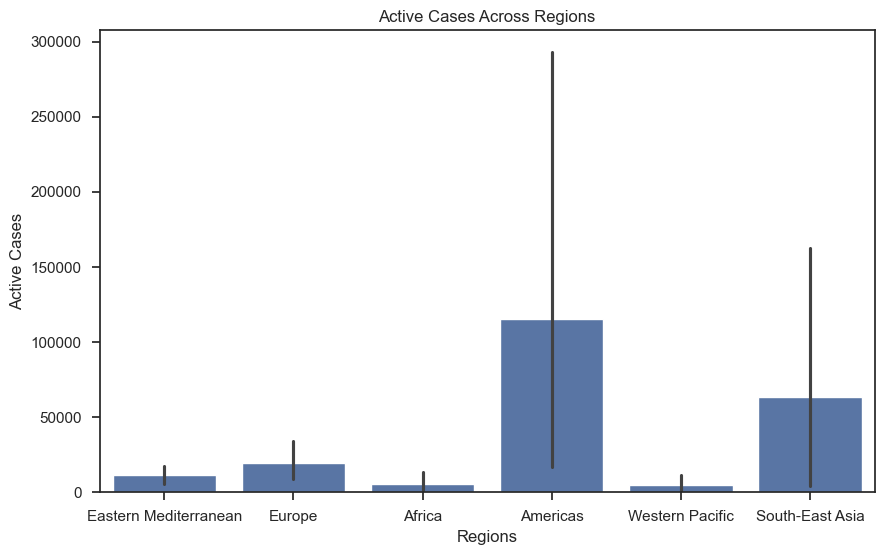

In [199]:
plt.figure(figsize =(10, 6))
sns.barplot(x=CW.WHO_Region, y=CW.Active)
plt.ylabel('Active Cases')
plt.xlabel('Regions')
plt.title('Active Cases Across Regions')
plt.savefig("active.png")
plt.show()
          

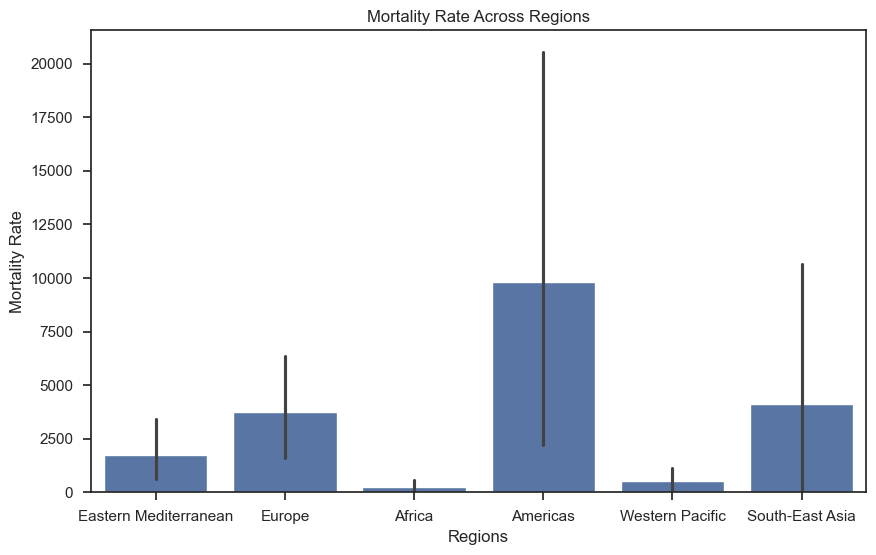

In [201]:
plt.figure(figsize =(10, 6))
sns.barplot(x=CW.WHO_Region, y=CW.Deaths)
plt.ylabel('Mortality Rate')
plt.xlabel('Regions')
plt.title('Mortality Rate Across Regions')
plt.savefig("mortality_Reg.png")
plt.show()

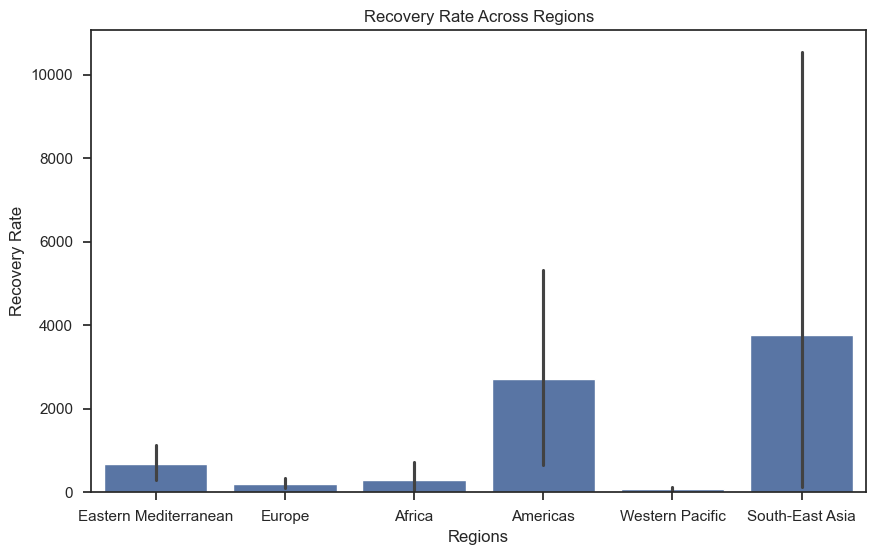

In [203]:
plt.figure(figsize =(10, 6))
sns.barplot(x=CW.WHO_Region, y=CW.New_Recovered)
plt.ylabel('Recovery Rate')
plt.xlabel('Regions')
plt.title('Recovery Rate Across Regions')
plt.savefig("recovered_Cases_Reg.png")
plt.show()

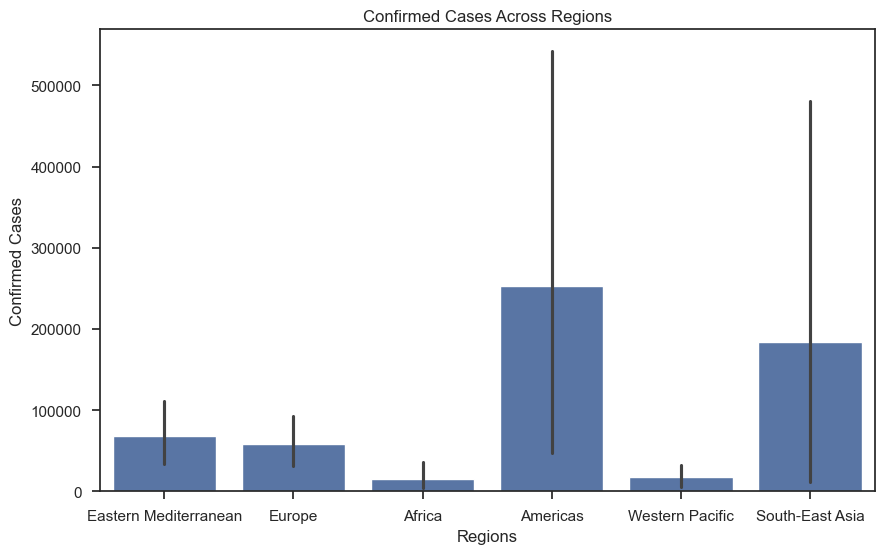

In [205]:
plt.figure(figsize =(10, 6))
sns.barplot(x=CW.WHO_Region, y=CW.Confirmed)
plt.ylabel('Confirmed Cases')
plt.xlabel('Regions')
plt.title('Confirmed Cases Across Regions')
plt.savefig("con_Cases_Reg.png")
plt.show()

In [207]:
##Loading Third Data for Classification Task
DF= pd.read_excel("C:/Users/AFRIFA/Documents/CAPSTONE TASK/worldometer_data.xlsx")

Data Cleaning

In [210]:
##Checking for Misssing Values
DF.isnull().sum()

Country/Region        0
Continent             1
Population            1
TotalCases            0
NewCases            205
TotalDeaths          21
NewDeaths           206
TotalRecovered        4
NewRecovered        206
ActiveCases           4
Serious,Critical     87
Tot Cases/1M pop      1
Deaths/1M pop        22
TotalTests           18
Tests/1M pop         18
WHO Region           25
dtype: int64

In [212]:
## Checking Shape
DF.shape

(209, 16)

In [214]:
##Examining Data Information
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Country/Region    209 non-null    object 
 1   Continent         208 non-null    object 
 2   Population        208 non-null    float64
 3   TotalCases        209 non-null    int64  
 4   NewCases          4 non-null      float64
 5   TotalDeaths       188 non-null    float64
 6   NewDeaths         3 non-null      float64
 7   TotalRecovered    205 non-null    float64
 8   NewRecovered      3 non-null      float64
 9   ActiveCases       205 non-null    float64
 10  Serious,Critical  122 non-null    float64
 11  Tot Cases/1M pop  208 non-null    float64
 12  Deaths/1M pop     187 non-null    float64
 13  TotalTests        191 non-null    float64
 14  Tests/1M pop      191 non-null    float64
 15  WHO Region        184 non-null    object 
dtypes: float64(12), int64(1), object(3)
memory u

In [216]:
## Rebaming Columns
DF=DF.rename(columns={"Tot Cases/1M pop":  "Cases_Per_One_Million", 
                      "Deaths/1M pop": "Deaths_Per_One_Million",
                      "Tests/1M pop":  "Test_Per_One_Million"}) 

In [218]:
## Checking for Duplicates
DF.duplicated().sum()

0

In [219]:
##Replacing Missing row in Continent with the most occuring Continent
DF['Continent']=DF['Continent'].fillna(DF['Continent'].mode()[0])

In [222]:
##Selecting Feature and Target Variable
DDF=(DF[["Population", "TotalCases", "TotalDeaths", "TotalRecovered", "ActiveCases", "Cases_Per_One_Million", 
        "Deaths_Per_One_Million", "TotalTests", "Test_Per_One_Million"]])
DC=(DF['Continent'])

In [225]:
## Viewing the data
DDF

,Population,TotalCases,TotalDeaths,TotalRecovered,ActiveCases,Cases_Per_One_Million,Deaths_Per_One_Million,TotalTests,Test_Per_One_Million
0,3.311981e+08,5032179,162804.0,2576668.0,2292707.0,15194.0,492.0,63139605.0,190640.0
1,2.127107e+08,2917562,98644.0,2047660.0,771258.0,13716.0,464.0,13206188.0,62085.0
2,1.381345e+09,2025409,41638.0,1377384.0,606387.0,1466.0,30.0,22149351.0,16035.0
3,1.459409e+08,871894,14606.0,676357.0,180931.0,5974.0,100.0,29716907.0,203623.0
4,5.938157e+07,538184,9604.0,387316.0,141264.0,9063.0,162.0,3149807.0,53044.0
...,...,...,...,...,...,...,...,...,...
204,4.992000e+03,13,1.0,10.0,2.0,2604.0,200.0,61.0,12220.0
205,2.624700e+04,13,NaN,7.0,6.0,495.0,NaN,424.0,16154.0
206,3.489000e+03,13,NaN,13.0,0.0,3726.0,NaN,1816.0,520493.0
207,8.010000e+02,12,NaN,12.0,0.0,14981.0,NaN,NaN,NaN


In [226]:
##Replacing the missing numerical columns with KNN Imputation Method
imputer =KNNImputer(n_neighbors=3)
DFD= imputer.fit_transform(DDF)

In [229]:
## Creating a data frame after replacing missing values
DFD=pd.DataFrame(DFD, columns=DDF.columns)

In [231]:
DFD

,Population,TotalCases,TotalDeaths,TotalRecovered,ActiveCases,Cases_Per_One_Million,Deaths_Per_One_Million,TotalTests,Test_Per_One_Million
0,3.311981e+08,5032179.0,162804.000000,2576668.0,2292707.0,15194.0,492.000000,6.313960e+07,190640.000000
1,2.127107e+08,2917562.0,98644.000000,2047660.0,771258.0,13716.0,464.000000,1.320619e+07,62085.000000
2,1.381345e+09,2025409.0,41638.000000,1377384.0,606387.0,1466.0,30.000000,2.214935e+07,16035.000000
3,1.459409e+08,871894.0,14606.000000,676357.0,180931.0,5974.0,100.000000,2.971691e+07,203623.000000
4,5.938157e+07,538184.0,9604.000000,387316.0,141264.0,9063.0,162.000000,3.149807e+06,53044.000000
...,...,...,...,...,...,...,...,...,...
204,4.992000e+03,13.0,1.000000,10.0,2.0,2604.0,200.000000,6.100000e+01,12220.000000
205,2.624700e+04,13.0,5.666667,7.0,6.0,495.0,158.666667,4.240000e+02,16154.000000
206,3.489000e+03,13.0,7.666667,13.0,0.0,3726.0,466.000000,1.816000e+03,520493.000000
207,8.010000e+02,12.0,18.666667,12.0,0.0,14981.0,488.000000,7.670000e+02,182955.666667


In [233]:
##Checking for Missing Observations for Features
DFD.isnull().sum()

Population                0
TotalCases                0
TotalDeaths               0
TotalRecovered            0
ActiveCases               0
Cases_Per_One_Million     0
Deaths_Per_One_Million    0
TotalTests                0
Test_Per_One_Million      0
dtype: int64

In [235]:
##Checking for Missing Observations for Targe Variable
DC.isnull().sum()

0

In [237]:
## Mearging Both Into a Single Dataframe
DF=pd.concat([DFD, DC], axis =1, ignore_index=False)

In [239]:
## Examining them
DF.head(1)

,Population,TotalCases,TotalDeaths,TotalRecovered,ActiveCases,Cases_Per_One_Million,Deaths_Per_One_Million,TotalTests,Test_Per_One_Million,Continent
0,331198130.0,5032179.0,162804.0,2576668.0,2292707.0,15194.0,492.0,63139605.0,190640.0,North America


In [241]:
## Feature Engineering
DF['Growth_Rate'] =DF['TotalCases'].pct_change(periods =1)*100
DF['Recovery_Rate'] =DF['TotalRecovered'].pct_change(periods =1)*100
DF['Mortality_Rate'] =DF['TotalDeaths'].pct_change(periods =1)*100
DF['Cases_Per_1Million_Population']=(DF['TotalCases'])/(DF['Population']/1000000)
DF['Test_Per_1Million_Population']=(DF['TotalTests'])/(DF['Population']/1000000)
DF['Deaths_Per_1Million']=(DF['TotalDeaths'])/(DF['Population']/1000000)
DF['Recovered_Per_1Million']=(DF['TotalRecovered'])/(DF['Population']/1000000)
DF['Recovery_To_Death_Rates']=(DF['TotalCases'])/(DF['Population'])*100
DF['Recovery_Rate_To_Cases']=(DF['TotalRecovered'])/(DF['TotalCases'])*100
DF['Mortality_Rate_To_Active_Cases']=(DF['TotalDeaths'])/(DF['ActiveCases'])*100

In [243]:
## Checking for Missing cases after feature engineering
DF.isnull().sum()

Population                        0
TotalCases                        0
TotalDeaths                       0
TotalRecovered                    0
ActiveCases                       0
Cases_Per_One_Million             0
Deaths_Per_One_Million            0
TotalTests                        0
Test_Per_One_Million              0
Continent                         0
Growth_Rate                       1
Recovery_Rate                     1
Mortality_Rate                    1
Cases_Per_1Million_Population     0
Test_Per_1Million_Population      0
Deaths_Per_1Million               0
Recovered_Per_1Million            0
Recovery_To_Death_Rates           0
Recovery_Rate_To_Cases            0
Mortality_Rate_To_Active_Cases    0
dtype: int64

In [245]:
##Droping missing rows
DF=DF.dropna()

In [247]:
## Checking againg
DF.head(1)

,Population,TotalCases,TotalDeaths,TotalRecovered,ActiveCases,Cases_Per_One_Million,Deaths_Per_One_Million,TotalTests,Test_Per_One_Million,Continent,Growth_Rate,Recovery_Rate,Mortality_Rate,Cases_Per_1Million_Population,Test_Per_1Million_Population,Deaths_Per_1Million,Recovered_Per_1Million,Recovery_To_Death_Rates,Recovery_Rate_To_Cases,Mortality_Rate_To_Active_Cases
1,212710692.0,2917562.0,98644.0,2047660.0,771258.0,13716.0,464.0,13206188.0,62085.0,South America,-42.021895,-20.530701,-39.409351,13716.104125,62085.210084,463.747257,9626.502461,1.37161,70.183941,12.790013


In [248]:
## Selecting 8 Features, and also collecting the label variable
Feature_Variables = (DF[["Cases_Per_1Million_Population", 
                         "Test_Per_1Million_Population", 
                         "Deaths_Per_1Million", 
                         "Recovery_To_Death_Rates", 
                         "Growth_Rate", 
                         "TotalTests",  
                         "Recovery_Rate", 
                         "Recovered_Per_1Million"]])
Y =DF['Continent']
X =Feature_Variables

In [251]:
## Counting the frequency of the Label
Y.value_counts()

Continent
Africa               58
Asia                 48
Europe               48
North America        34
South America        14
Australia/Oceania     6
Name: count, dtype: int64

In [253]:
##Data Transformation using Z-Score Transformation
X_Variables = StandardScaler()
X_Variables =X_Variables.fit_transform(X)


In [255]:
##Puting the data into a dataframe
Scaled_Feat =pd.DataFrame(X_Variables, columns =X.columns)

In [257]:
##Splitting the Data for analysis
X_Train, X_Test, Y_Train, Y_Test =train_test_split(Scaled_Feat, Y, test_size=0.30, stratify =Y, random_state =40)

In [259]:
##Building the decision tree model
My_model =tree.DecisionTreeClassifier(criterion = 'gini', max_depth = 5, random_state=15)
My_model.fit(X_Train.values, Y_Train)

DecisionTreeClassifier(max_depth=5, random_state=15)

In [261]:
Y_pred = My_model.predict(X_Test.values)

In [263]:
##Checking the model predictions
Assessing=pd.DataFrame({'Actual_Values':Y_Test,'Predicted Values':Y_pred})
Assessing.head(10)

,Actual_Values,Predicted Values
140,Asia,Africa
118,Africa,Asia
192,North America,North America
18,Europe,Europe
124,Africa,Africa
55,Asia,Europe
136,Europe,Africa
166,Africa,Africa
115,North America,Africa
66,Africa,Africa


In [264]:
##Model Evaluation
CM=confusion_matrix(Y_Test, Y_pred)
print(CM)

[[13  3  0  0  2  0]
 [ 9  3  0  3  0  0]
 [ 0  0  0  0  2  0]
 [ 3  0  0  7  3  1]
 [ 3  1  0  0  5  1]
 [ 3  0  0  0  0  1]]


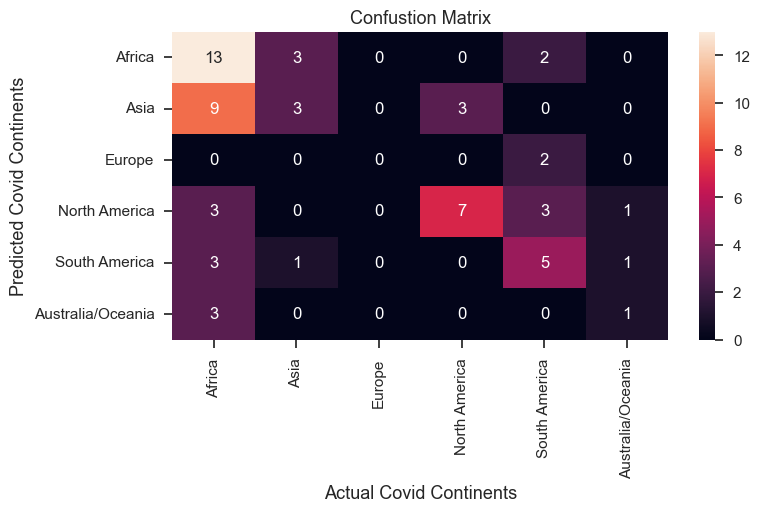

In [267]:
##Visualising the Matrix using heatmap
CFM=pd.DataFrame(CM, index= ["Africa", "Asia", "Europe",  "North America", "South America", "Australia/Oceania"],
                         columns=["Africa", "Asia", "Europe",  "North America", "South America", "Australia/Oceania"])
plt.figure(figsize=(8,4))
sns.heatmap(CFM, annot =True)
plt.ylabel('Predicted Covid Continents', fontsize =13)
plt.xlabel('Actual Covid Continents', fontsize =13)
plt.title('Confustion Matrix', fontsize =13)
plt.savefig('Cconfusion at.png', dpi =300, bbox_inches ='tight')
plt.show()

In [269]:
print(classification_report(Y_Test.values, Y_pred))

                   precision    recall  f1-score   support

           Africa       0.42      0.72      0.53        18
             Asia       0.43      0.20      0.27        15
Australia/Oceania       0.00      0.00      0.00         2
           Europe       0.70      0.50      0.58        14
    North America       0.42      0.50      0.45        10
    South America       0.33      0.25      0.29         4

         accuracy                           0.46        63
        macro avg       0.38      0.36      0.35        63
     weighted avg       0.46      0.46      0.44        63



C:\Users\AFRIFA\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\AFRIFA\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\AFRIFA\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


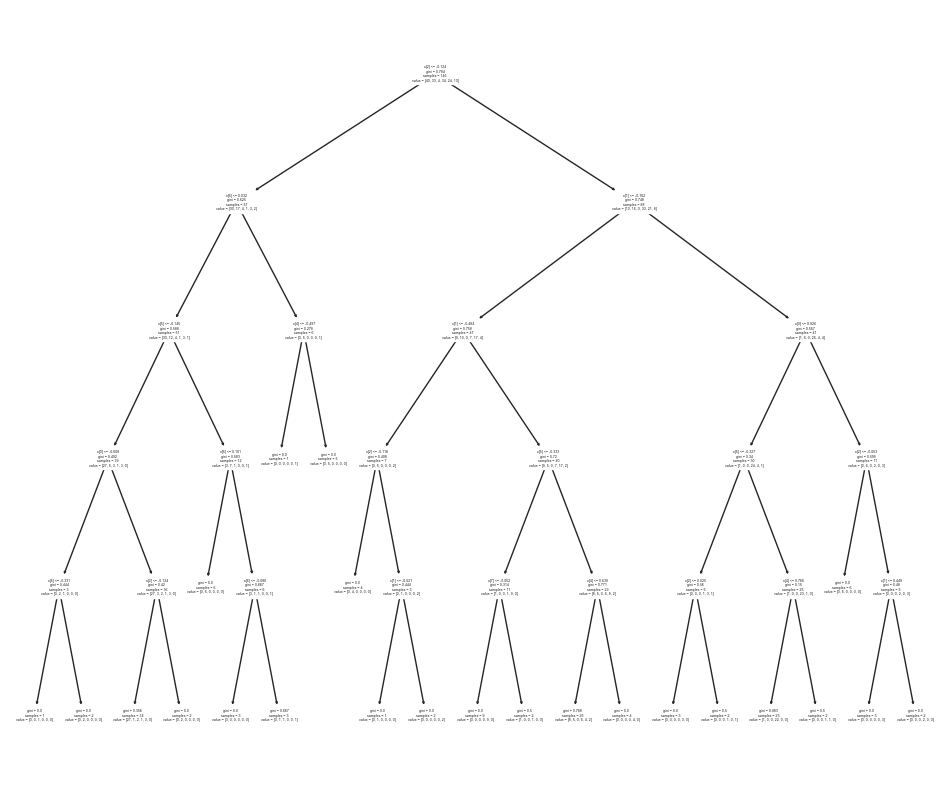

In [271]:
plt.figure(figsize=(12, 10))
tree.plot_tree(My_model.fit(X_Train.values, Y_Train))
plt.savefig("ctree  at.png")
plt.show()

In [274]:
##Checking Model Score for both training and test data
print ('Training Set Score: {:.4f}'.format(My_model.score(X_Train.values, Y_Train)))
print ('Test Set Score: {:.4f}'.format(My_model.score(X_Test.values, Y_Test)))

Training Set Score: 0.7931
Test Set Score: 0.4603


In [276]:
##Identifying a possible continent given specific realities about COVID
Indenfy_a_Continent =My_model.predict([[-0.588077,	-0.534983,	-0.131192,	-0.588077,	0.274491,	-0.328950,	0.349332,	-0.492776]])

In [278]:
Indenfy_a_Continent 

array(['Asia'], dtype=object)